In [1]:
import pandas as pd
import matplotlib
from IPython.display import display, Markdown

In [2]:
VACCINATION_DATA = '../raw_data/nyc/covid19-vaccine/Population Vaccinated + Doses Administered_Migrated Data.tsv'
CENSUS_DATA = '../raw_data/nyc/census/2019-NYS-population-estimates_census-gov.csv'

NYC_CENSUS_NAME = 'New York city'

DAILY = 'Daily ' # Trailing space required

HERD_PERCENT = 0.85 # https://www.vox.com/coronavirus-covid19/2020/12/15/22176555/anthony-fauci-covid-19-vaccine-herd-immunity-goal

In [3]:
vax_raw = pd.read_csv(VACCINATION_DATA, sep='\t', encoding = 'utf-16')
census_raw = pd.read_csv(CENSUS_DATA)

In [4]:
vax_clean = vax_raw.copy()
vax_clean['Date'] = pd.to_datetime(vax_raw['Date'])
vax_clean['Today'] = pd.to_datetime(vax_raw['Today'])
vax_clean = vax_clean[vax_clean['Cumulative or daily'] == 'Daily ']

## Trim to necessary columns
vax_clean = vax_clean[['Date', 'Residency', 'N fully vaccinated', 'N partially vaccinated']]

## grouped by preceding Sunday, so we can remove daily seasonality (aka weekends are low)
vax_clean['Week Start'] = vax_clean['Date'].apply(lambda d: d - pd.to_timedelta(((d.weekday() + 1) % 7), unit='d'))
vax_weekly = vax_clean.groupby(['Week Start', 'Residency'], as_index=False).sum()

## Create an NYC only set for comparing to population
vax_nyc = vax_clean[vax_clean['Residency'] == 'NYC']
vax_nyc_weekly = vax_nyc.groupby(['Week Start', 'Residency'], as_index=False).sum()

In [5]:
## One way this is obviously wrong is that since a lot of people have gotten covid in NYC, they (might?) already have immunity

NYC_2019_POP = census_raw[census_raw['NAME'] == NYC_CENSUS_NAME].iloc[0].loc['POPESTIMATE2019']
NYC_VACCINATION_NUMBER = NYC_2019_POP * HERD_PERCENT

# How many people have been vaccinated?

<AxesSubplot:>

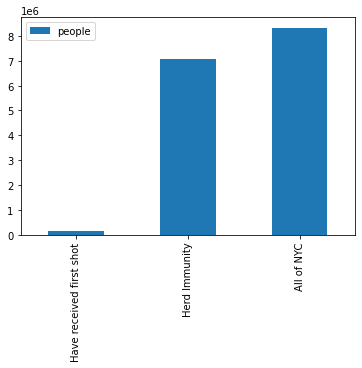

In [6]:
first_shots = vax_nyc.sum()['N partially vaccinated']

perc_of_pop = first_shots / NYC_2019_POP
pop_pretty = f'{perc_of_pop:.2%}'

df = pd.DataFrame(
    [first_shots, NYC_VACCINATION_NUMBER, NYC_2019_POP], 
    index=['Have received first shot', 'Herd Immunity', 'All of NYC'], 
    columns=['people'])
df.plot.bar()


# How quickly are we vaccinating?

<AxesSubplot:xlabel='Week Start'>

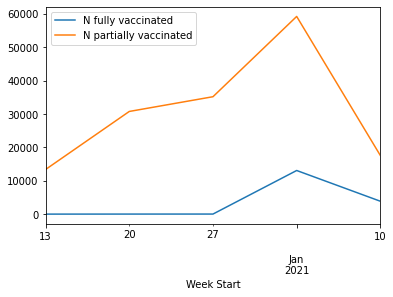

In [7]:
vax_nyc_weekly.plot(x='Week Start')

# How long until we reach immunity?

In [8]:
avg_last_7 = vax_nyc.sort_values('Date').tail(7).mean(numeric_only=True)['N partially vaccinated']
avg_prev_7 = vax_nyc.sort_values('Date').tail(14).head(7).mean(numeric_only=True)['N partially vaccinated']

growth = avg_last_7 - avg_prev_7

weeks = 0
this_week = avg_last_7
while this_week <= NYC_VACCINATION_NUMBER:
    weeks += 1
    this_week += growth

Markdown(f'### It will take _{weeks:,}_ weeks to vaccinate enough people, based on current linear growth rates')

### It will take _1,592_ weeks to vaccinate enough people, based on current linear growth rates